## This is a project to predict the shopper's shopping time 

### Importing libraries and helper functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error
import xgboost as xgb

In [2]:
%matplotlib inline

In [3]:
# h1
def count_unique_value(x):
    return len(np.unique(x))

In [4]:
# h2
def add_groupby_features(data, group_by_list, aggr_input, keep_original=False):
    """ 
    : data: a data frame as input
    : group_by_list: a list of columns to group by
    : aggr_input: a dictionary of mapping output
    : keep_original: whether merge the new features or not
    : return a df
    """
    
    data_copy = data.copy()
    new_features = data_copy.groupby(group_by_list).agg(aggr_input)
    new_features.columns = new_features.columns.droplevel(0)
    new_features.reset_index(inplace = True)
    if keep_original:
        result = pd.merge(left = data_copy,
                            right = new_features,
                            on = group_by_list,
                            how = 'left')
    else:
        result = new_features
    
    return result

### Import data

In [5]:
order_items = pd.read_csv('../instacart-picking-time-challenge-data/order_items.csv')
test_df = pd.read_csv('../instacart-picking-time-challenge-data/test_trips.csv')
train_df = pd.read_csv('../instacart-picking-time-challenge-data/train_trips.csv')

In [6]:
order_items.head()

trip_id  item_id department_name  quantity
0  3119513   368671         Produce      10.0
1  3120462   368671         Produce      10.0
2  3120473   368671         Produce      10.0
3  3121910   368671         Produce       6.0
4  3122332   368671         Produce      10.0

In [7]:
train_df.head()

trip_id  shopper_id fulfillment_model  store_id  shopping_started_at  \
0  3119519       48539           model_1         6  2015-09-01 07:03:56   
1  3119513        3775           model_1         1  2015-09-01 07:04:33   
2  3119516        4362           model_1         1  2015-09-01 07:23:21   
3  3119792       47659           model_1         1  2015-09-01 07:29:52   
4  3119922       11475           model_1         1  2015-09-01 07:32:21   

     shopping_ended_at  
0  2015-09-01 07:30:56  
1  2015-09-01 07:40:33  
2  2015-09-01 07:41:21  
3  2015-09-01 08:55:52  
4  2015-09-01 09:01:21

In [8]:
test_df.head()

trip_id  shopper_id fulfillment_model  store_id  shopping_started_at
0  4310899       60930           model_2       123  2015-11-16 07:00:12
1  4310904       59815           model_2       123  2015-11-16 07:00:12
2  4310907       60878           model_2       123  2015-11-16 07:00:13
3  4310911       60879           model_2       123  2015-11-16 07:00:13
4  4310328       66726           model_1         1  2015-11-16 07:01:08

### Exploring data

In [9]:
print('order_items shape: {0} \n'.format(order_items.shape))
print('training data shape: {0} \n'.format(train_df.shape))
print('testing data shape: {0} \n'.format(test_df.shape))

order_items shape: (2040286, 4) 

training data shape: (117063, 6) 

testing data shape: (11647, 5) 



In [10]:
trip_count = count_unique_value(order_items['trip_id'])
print 'number of unique trip id in table order_items is {0}'.format(trip_count)
trip_count_train = count_unique_value(train_df['trip_id'])
print 'number of unique trip id in table train_df is {0}'.format(trip_count_train)
trip_count_test = count_unique_value(test_df['trip_id'])
print 'number of unique trip id in table train_df is {0}'.format(trip_count_test)
print 'test + train == total unique trips: {}'.format(trip_count == trip_count_train + trip_count_test)

number of unique trip id in table order_items is 128710
number of unique trip id in table train_df is 117063
number of unique trip id in table train_df is 11647
test + train == total unique trips: True


In [11]:
# see an example:
sample_trip = order_items[order_items['trip_id'] == 3119513]
len(np.unique(sample_trip.department_name))

8

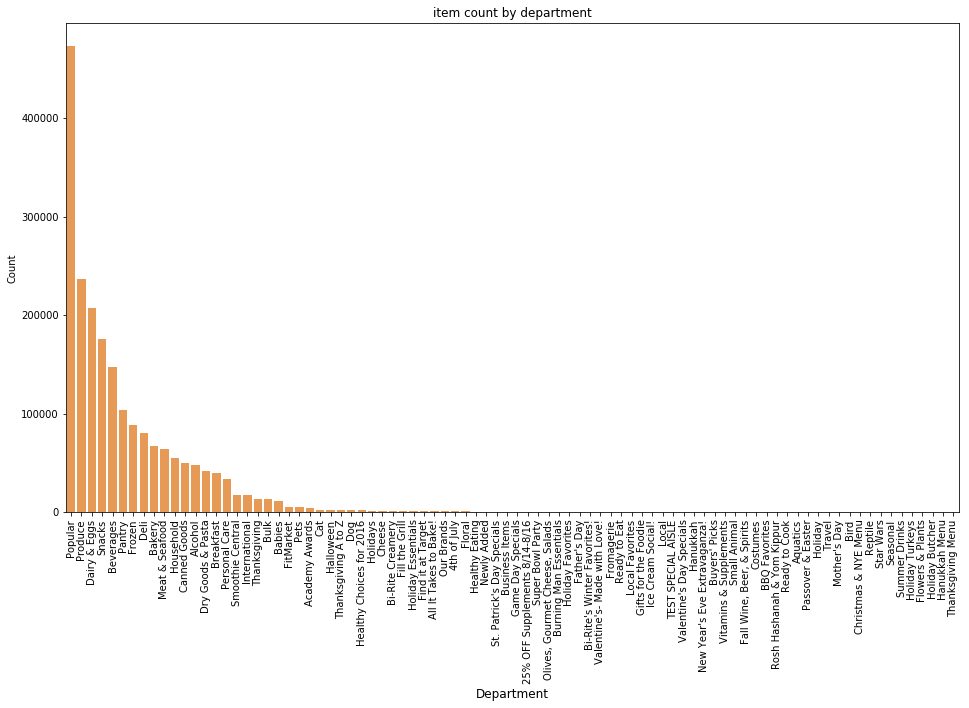

In [12]:
trip_count = order_items.department_name.value_counts()
plt.figure(figsize=(16, 9))
sns.barplot(trip_count.index, trip_count.values, alpha=0.8, color=color[1])
plt.ylabel('Count', fontsize=10)
plt.xlabel('Department', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('item count by department')
plt.show()

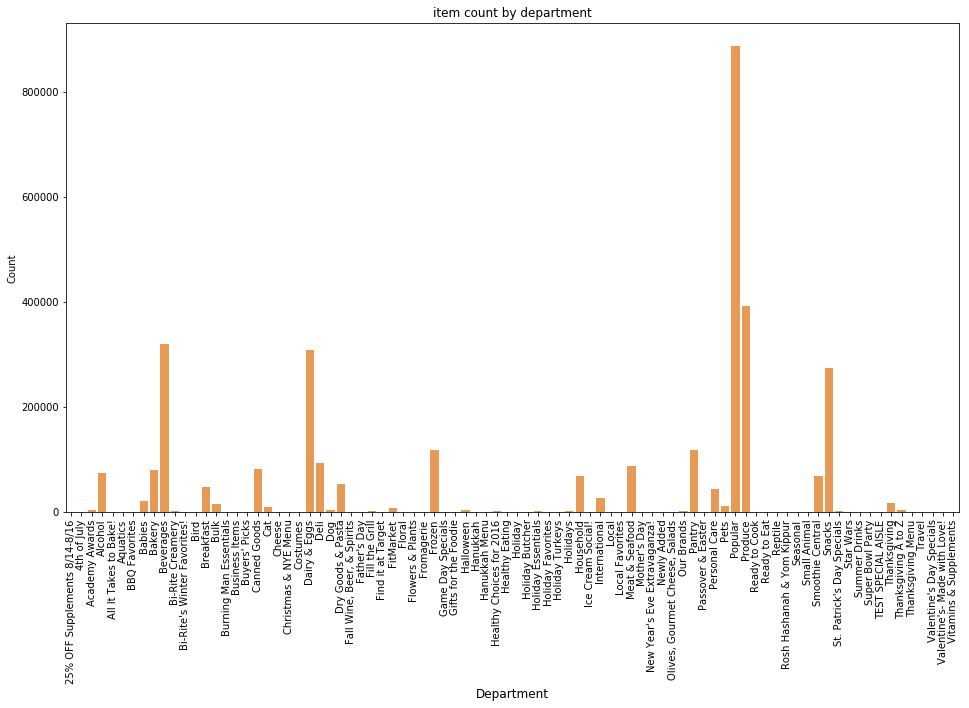

In [13]:
quant_count_by_dpmt = order_items.groupby('department_name')['quantity'].aggregate(np.sum).reset_index()
plt.figure(figsize=(16, 9))
sns.barplot(quant_count_by_dpmt.department_name, quant_count_by_dpmt.quantity, alpha=0.8, color=color[1])
plt.ylabel('Count', fontsize=10)
plt.xlabel('Department', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('item count by department')
plt.show()

In [14]:
print "Training set:"
shopper_count = count_unique_value(train_df['shopper_id'])
print 'number of shoppers id in table order_items is {0}'.format(shopper_count)
store_count = count_unique_value(train_df['store_id'])
print 'number of store id in table order_items is {0}'.format(store_count)
ff_model_count = count_unique_value(train_df['fulfillment_model'])
print 'number of shoppers id in table order_items is {0}'.format(ff_model_count)

Training set:
number of shoppers id in table order_items is 1506
number of store id in table order_items is 14
number of shoppers id in table order_items is 2


In [15]:
print "Testing set:"
shopper_count = count_unique_value(test_df['shopper_id'])
print 'number of shoppers id in table order_items is {0}'.format(shopper_count)
store_count = count_unique_value(test_df['store_id'])
print 'number of store id in table order_items is {0}'.format(store_count)
ff_model_count = count_unique_value(test_df['fulfillment_model'])
print 'number of shoppers id in table order_items is {0}'.format(ff_model_count)

Testing set:
number of shoppers id in table order_items is 804
number of store id in table order_items is 12
number of shoppers id in table order_items is 2


In [16]:
# double checking store id in training set
np.unique(train_df.store_id)

array([  1,   3,   5,   6,  29,  31,  54,  78,  90, 105, 115, 123, 126, 148])

In [17]:
# double checking store id in testing set
np.unique(test_df.store_id)

array([  1,   3,   5,   6,  29,  31,  54,  90, 105, 115, 123, 126])

### Preprocessing data set

In [18]:
summary_dict_i = {'item_id': {'total_unique_items' : 'count'},
               'department_name' : {'total_departments' : lambda x: x.nunique()},
               'quantity' : {'total_quantities' : 'sum'}}
order_details = add_groupby_features(data=order_items, group_by_list=['trip_id'], aggr_input=summary_dict_i)
order_details['avg_items_per_dpmt'] = order_details.total_unique_items / order_details.total_departments
order_details['avg_quant_per_dpmt'] = order_details.total_quantities / order_details.total_departments
order_details['avg_quant_per_item'] = order_details.total_quantities / order_details.total_unique_items
order_details.head()

/usr/local/lib/python2.7/dist-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


trip_id  total_unique_items  total_quantities  total_departments  \
0  3119513                  33             183.0                  8   
1  3119516                   5               9.0                  5   
2  3119518                  12              21.0                  6   
3  3119519                  26              39.0                 11   
4  3119520                  33              36.0                 14   

   avg_items_per_dpmt  avg_quant_per_dpmt  avg_quant_per_item  
0            4.125000           22.875000            5.545455  
1            1.000000            1.800000            1.800000  
2            2.000000            3.500000            1.750000  
3            2.363636            3.545455            1.500000  
4            2.357143            2.571429            1.090909

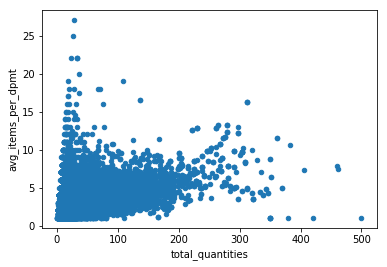

In [19]:
order_details.plot(x = 'total_quantities', y = 'avg_items_per_dpmt', kind = 'scatter')

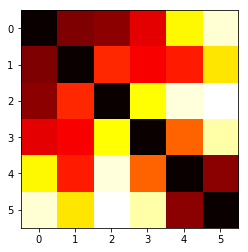

total_unique_items  total_quantities  total_departments  \
total_unique_items            1.000000          0.806106           0.782003   
total_quantities              0.806106          1.000000           0.532786   
total_departments             0.782003          0.532786           1.000000   
avg_items_per_dpmt            0.638915          0.603473           0.174554   
avg_quant_per_dpmt            0.184863          0.554458          -0.066389   
avg_quant_per_item           -0.057456          0.217893          -0.106002   

                    avg_items_per_dpmt  avg_quant_per_dpmt  avg_quant_per_item  
total_unique_items            0.638915            0.184863           -0.057456  
total_quantities              0.603473            0.554458            0.217893  
total_departments             0.174554           -0.066389           -0.106002  
avg_items_per_dpmt            1.000000            0.432076           -0.008660  
avg_quant_per_dpmt            0.432076            1.000000            0.786581  
avg_quant_per_item           -0.008660            0.786581            1.000000

In [20]:
# check correlations
cors = order_details.iloc[:, 1:].corr()
# total_unique_items is highly correlated to total quantities  and departments
plt.imshow(cors * (-1), cmap='hot', interpolation='nearest')
plt.show()
cors

In [21]:
train_df.head()

trip_id  shopper_id fulfillment_model  store_id  shopping_started_at  \
0  3119519       48539           model_1         6  2015-09-01 07:03:56   
1  3119513        3775           model_1         1  2015-09-01 07:04:33   
2  3119516        4362           model_1         1  2015-09-01 07:23:21   
3  3119792       47659           model_1         1  2015-09-01 07:29:52   
4  3119922       11475           model_1         1  2015-09-01 07:32:21   

     shopping_ended_at  
0  2015-09-01 07:30:56  
1  2015-09-01 07:40:33  
2  2015-09-01 07:41:21  
3  2015-09-01 08:55:52  
4  2015-09-01 09:01:21

In [22]:
train_df['shopping_time'] = (pd.to_datetime(train_df.shopping_ended_at) - pd.to_datetime(train_df.shopping_started_at)).astype('timedelta64[s]')
train_df.head()

trip_id  shopper_id fulfillment_model  store_id  shopping_started_at  \
0  3119519       48539           model_1         6  2015-09-01 07:03:56   
1  3119513        3775           model_1         1  2015-09-01 07:04:33   
2  3119516        4362           model_1         1  2015-09-01 07:23:21   
3  3119792       47659           model_1         1  2015-09-01 07:29:52   
4  3119922       11475           model_1         1  2015-09-01 07:32:21   

     shopping_ended_at  shopping_time  
0  2015-09-01 07:30:56         1620.0  
1  2015-09-01 07:40:33         2160.0  
2  2015-09-01 07:41:21         1080.0  
3  2015-09-01 08:55:52         5160.0  
4  2015-09-01 09:01:21         5340.0

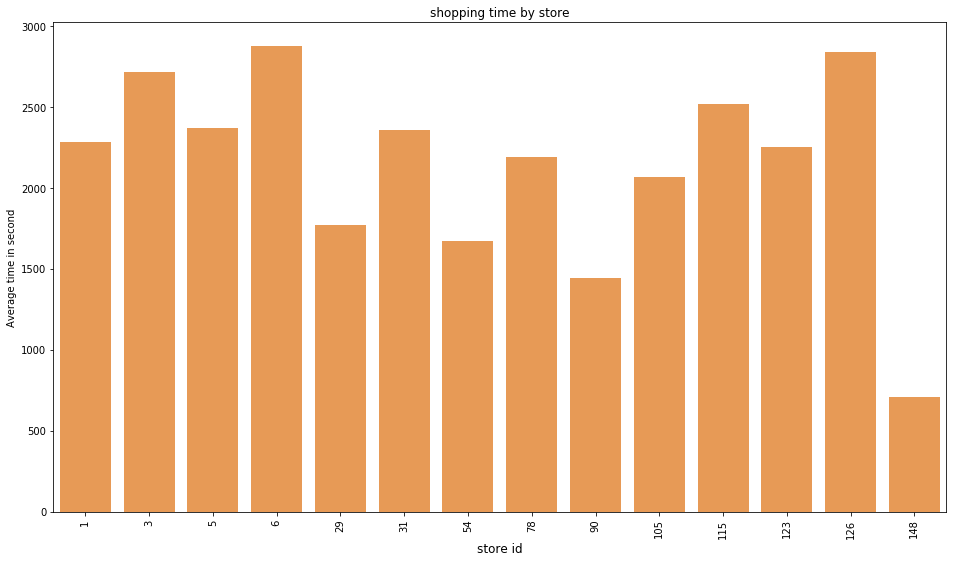

In [23]:
shopping_time_by_store = train_df.groupby('store_id')['shopping_time'].aggregate(np.average).reset_index()
plt.figure(figsize=(16, 9))
sns.barplot(shopping_time_by_store.store_id, shopping_time_by_store.shopping_time, alpha=0.8, color=color[1])
plt.ylabel('Average time in second', fontsize=10)
plt.xlabel('store id', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('shopping time by store')
plt.show()

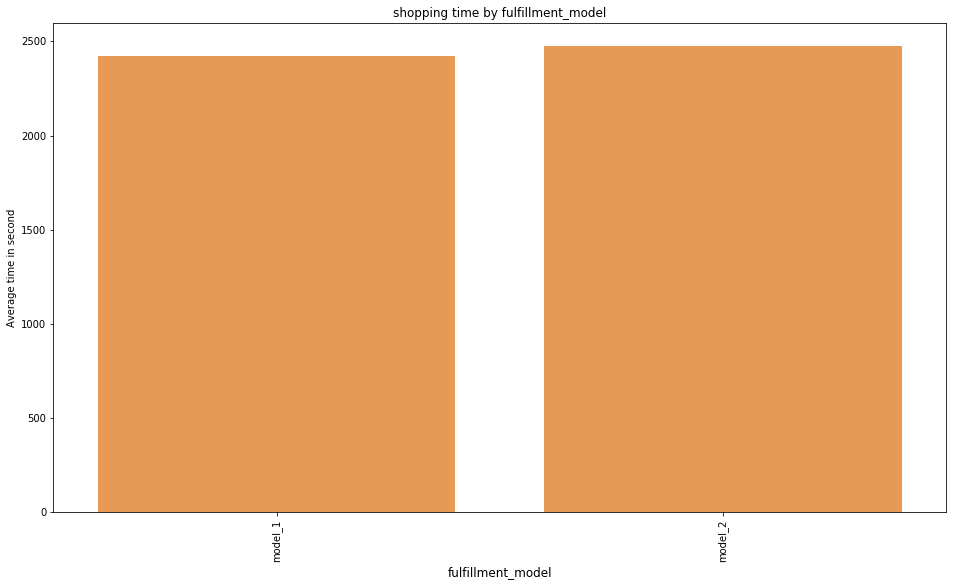

In [24]:
shopping_time_by_fulfillment_model = train_df.groupby('fulfillment_model')['shopping_time'].aggregate(np.average).reset_index()
plt.figure(figsize=(16, 9))
sns.barplot(shopping_time_by_fulfillment_model.fulfillment_model, shopping_time_by_fulfillment_model.shopping_time, alpha=0.8, color=color[1])
plt.ylabel('Average time in second', fontsize=10)
plt.xlabel('fulfillment_model', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('shopping time by fulfillment_model')
plt.show()

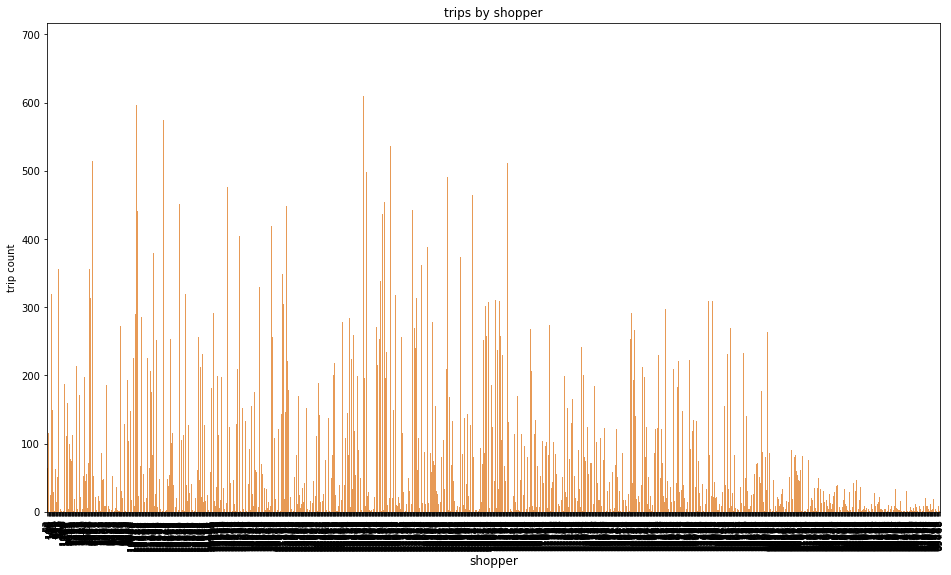

In [25]:
trips_by_shopper = train_df.shopper_id.value_counts()
plt.figure(figsize=(16, 9))
sns.barplot(trips_by_shopper.index, trips_by_shopper.values, alpha=0.8, color=color[1])
plt.ylabel('trip count', fontsize=10)
plt.xlabel('shopper', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('trips by shopper')
plt.show()

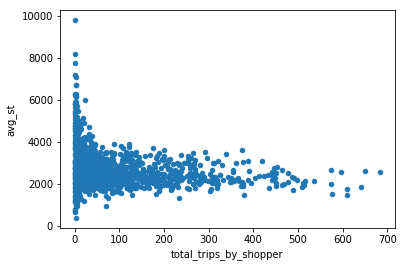

In [26]:
trips_shopping_time_by_shopper = add_groupby_features(data=train_df, 
                                                      group_by_list=['shopper_id'], 
                                                      aggr_input={'trip_id':{'total_trips_by_shopper':'count'},
                                                                 'shopping_time' : {'avg_st':'mean'},
                                                                 'store_id' : {'store_by_shopper':lambda x: x.nunique()}}, keep_original=False)
trips_shopping_time_by_shopper.plot(x= 'total_trips_by_shopper', y = 'avg_st', kind = 'scatter')

In [27]:
train_df = train_df.merge(right = trips_shopping_time_by_shopper[['shopper_id', 'total_trips_by_shopper', 'store_by_shopper']], 
                          on=['shopper_id'], 
                          how='inner')
train_df.head()

trip_id  shopper_id fulfillment_model  store_id  shopping_started_at  \
0  3119519       48539           model_1         6  2015-09-01 07:03:56   
1  3120866       48539           model_1         1  2015-09-01 08:43:32   
2  3122268       48539           model_1         6  2015-09-01 10:12:48   
3  3124212       48539           model_1         3  2015-09-01 11:53:23   
4  3138741       48539           model_1         3  2015-09-02 13:44:08   

     shopping_ended_at  shopping_time  total_trips_by_shopper  \
0  2015-09-01 07:30:56         1620.0                      67   
1  2015-09-01 08:58:32          900.0                      67   
2  2015-09-01 11:12:48         3600.0                      67   
3  2015-09-01 12:20:23         1620.0                      67   
4  2015-09-02 14:41:08         3420.0                      67   

   store_by_shopper  
0                11  
1                11  
2                11  
3                11  
4                11

In [28]:
trips_shopping_time_by_shopper_test = add_groupby_features(data=test_df, 
                                                      group_by_list=['shopper_id'], 
                                                      aggr_input={'trip_id':{'total_trips_by_shopper':'count'},
                                                                 'store_id' : {'store_by_shopper':lambda x: x.nunique()}}, keep_original=False)
test_df = test_df.merge(right = trips_shopping_time_by_shopper_test[['shopper_id', 'total_trips_by_shopper', 'store_by_shopper']], 
                          on=['shopper_id'], 
                          how='inner')
test_df.head()

trip_id  shopper_id fulfillment_model  store_id  shopping_started_at  \
0  4310899       60930           model_2       123  2015-11-16 07:00:12   
1  4311860       60930           model_2       123  2015-11-16 07:43:52   
2  4314363       60930           model_2       123  2015-11-16 09:02:19   
3  4315562       60930           model_2       123  2015-11-16 09:37:27   
4  4310904       59815           model_2       123  2015-11-16 07:00:12   

   total_trips_by_shopper  store_by_shopper  
0                       4                 1  
1                       4                 1  
2                       4                 1  
3                       4                 1  
4                      15                 1

In [29]:
train_set_merge = pd.merge(left=train_df,right=order_details, on='trip_id', how='left')
train_set_merge.drop(['total_trips_by_shopper', 'store_by_shopper', 'store_id', 'trip_id','shopper_id', 'fulfillment_model', 'shopping_started_at', 'shopping_ended_at'], axis=1,inplace=True)

In [30]:
X = train_set_merge.copy()
y = X[['shopping_time']]
X.drop('shopping_time', axis=1,inplace=True)
X.head()

total_unique_items  total_quantities  total_departments  \
0                  26              39.0                 11   
1                  18             103.0                  4   
2                  43             194.0                 10   
3                   4              13.0                  4   
4                  15              26.0                 10   

   avg_items_per_dpmt  avg_quant_per_dpmt  avg_quant_per_item  
0            2.363636            3.545455            1.500000  
1            4.500000           25.750000            5.722222  
2            4.300000           19.400000            4.511628  
3            1.000000            3.250000            3.250000  
4            1.500000            2.600000            1.733333

In [31]:
test_set_merge = pd.merge(left=test_df,right=order_details, on='trip_id', how='left')
test_set_merge.drop(['total_trips_by_shopper', 'store_by_shopper', 'store_id', 'shopper_id', 'fulfillment_model', 'shopping_started_at'], axis=1,inplace=True)

In [32]:
X_test_final = test_set_merge.copy()
X_test_final.drop('trip_id', axis=1, inplace=True)

In [33]:
X_test_final.head()

total_unique_items  total_quantities  total_departments  \
0                  16              28.0                  9   
1                  40              86.0                 10   
2                  18              18.0                 11   
3                  16              19.0                  9   
4                  39              48.0                 15   

   avg_items_per_dpmt  avg_quant_per_dpmt  avg_quant_per_item  
0            1.777778            3.111111            1.750000  
1            4.000000            8.600000            2.150000  
2            1.636364            1.636364            1.000000  
3            1.777778            2.111111            1.187500  
4            2.600000            3.200000            1.230769

In [35]:
from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
ss_y = StandardScaler()
X = ss_x.fit_transform(X)
X_test_final = ss_x.transform(X_test_final)
y = ss_y.fit_transform(y)


In [40]:
y_train

array([[-1.00717013],
       [ 1.13876366],
       [ 0.00268106],
       ..., 
       [-1.25963293],
       [-0.333936  ],
       [-0.92301587]])

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [38]:
X_test.shape

(35119, 6)

### Training models

In [ ]:
params={
    'max_depth': [2,3,4,5],
    'learning_rate': [0.01, 0.03, 0.1, 0.3],
    'colsample_bytree': [0.5,0.6,0.7,0.8],
    'n_estimators': [10,30,50],
    'gamma' : [1, 3 ,5],
    'reg_lambda': [0.01, 0.02, 0.03, 0.04]
}

xgb_reg = xgb.XGBRegressor(missing=9999999999)
regressor = GridSearchCV(xgb_reg,
                  params,
                  cv=5,
                  scoring="neg_mean_squared_error",
                  n_jobs=4,
                  verbose=2)
regressor.fit(X_train, y_train)
best_xgb = regressor.best_estimator_

In [ ]:
y_train_pred = best_xgb.predict(X_train)
mae_tr = mean_absolute_error(y_train_pred, y_train)
mse_tr = mean_squared_error(y_train_pred, y_train)
print('Mean absolute error of the best model in training subset: {0}.'.format(mae_tr))
print('Mean squared error of the best model in training subset: {0}.'.format(mse_tr))

In [ ]:
y_validation = best_xgb.predict(X_test)
mae = mean_absolute_error(y_validation, y_test)
mse = mean_squared_error(y_validation, y_test)
print('Mean absolute error of the best model in testing subset: {0}.'.format(mae))
print('Mean squared error of the best model in testing subset: {0}.'.format(mse))


In [ ]:
xgb_reg = xgb.XGBRegressor(missing=9999999999)
xgb_reg.fit(X_train, y_train)
validation_y = xgb_reg.predict(X_test)


In [ ]:
mae_t = mean_absolute_error(validation_y, y_test)
mse_t = mean_squared_error(validation_y, y_test)
print('Mean absolute error of the best model: {0}.'.format(mae_t))
print('Mean squared error of the best model: {0}.'.format(mse_t))

In [ ]:
plt.figure()
plt.scatter(X_test[0:15, 1], validation_y[0:15], color = 'red')
plt.scatter(X_test[0:15, 1], y_test[0:15], color = 'blue')
# y_plot.plot(x = 'st_pred', y = 'shopping_time', kind='scatter')
# plt.plot(x = y_plot.index, y = y_plot.st_pred)
plt.show()

In [ ]:
# Fitting Decision Tree Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state = 0)
dtr.fit(X_train, y_train)

# Predicting a new result
dtr_y_pred = dtr.predict(X_test)


In [ ]:
mae_t_dtr = mean_absolute_error(dtr_y_pred, y_test)
mse_t_dtr = mean_squared_error(dtr_y_pred, y_test)
print('Mean absolute error of the best model: {0}.'.format(mae_t_dtr))
print('Mean squared error of the best model: {0}.'.format(mse_t_dtr))

In [ ]:

plt.figure()
plt.scatter(X_test[0:15, 1], dtr_y_pred[0:15], color = 'red')
plt.scatter(X_test[0:15, 1], y_test[0:15], color = 'blue')
# y_plot.plot(x = 'st_pred', y = 'shopping_time', kind='scatter')
# plt.plot(x = y_plot.index, y = y_plot.st_pred)
plt.show()

In [39]:
# Fitting SVR to the dataset
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### Applying to the test data set

In [ ]:
y_test_final = best_xgb.predict(X_test_final)

In [ ]:
test_set_merge['shopping_time'] = y_test_final

In [ ]:
submissions = test_set_merge[['trip_id', 'shopping_time']]
submissions.to_csv('predictions.csv', index=False)